# Supply Chain EDA (full EDA with analysis available in pdf)
> **This file is temporary (will create python file for visualization and outcomes)** 😉

In this notebook we will take a dive into the costs and profits of all our orders. We will see, which products are the most profitable and which ones should, perhaps, be taken of the list.   
Among others, we will see:
- which product categories are ordered most often;
- which product categories are most often cancelled or possibly fraudulant;
- which products in each category bring in the most and the least profit;
- how do the customers types differ in the things they order;
- on which categories and which products is the company losing the most;
- what are the most and least expensive products;
- which categories are the most and least expensive, and averages, distribution of prices, kurtosis;
- which categories are the most discounted ones;
- how many sales are made per customer and sales total per customer;
- do small customer clustering via their buying patterns and PCA;
- if there are any trends in the order time and dates;
- if there is any weekly pattern in the shipement;
- many others ;)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
from scipy.stats import kurtosis, skew
from datetime import datetime
import pickle
import dataframe_image as dfi

pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

with open('data/supply_chain_dictionaties.pkl', 'rb') as file:
    dictionaries = pickle.load(file)

product_name = dictionaries[0]
department_name = dictionaries[1]
category_name = dictionaries[2]

In [2]:
df = pd.read_parquet('data/SupplyChainDataset_cleaned.parquet')
df['Order_time'] = df['Order_date'].dt.time
df['Shipping_time'] = df['Shipping_date'].dt.time
df['Shipping_date'] = df['Shipping_date'].dt.date
df['Order_date'] = df['Order_date'].dt.date
df.head()

,Type,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Category_Id,Customer_City,Customer_Country,Customer_Id,Customer_Segment,Customer_State,Department_Id,Market,Order_Country,Order_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Region,Order_Status,Product_Card_Id,Product_Price,Shipping_Mode,Shipping_date,Order_date,Order_time,Order_day,Shipping_time,Shipping_day,Target_shipping_days
0,CASH,88.79,239.98,0,43,Hickory,United States,11599,Consumer,NC,7,LATAM,México,1,60.00,0.20,1,0.37,1,299.98,Central America,CLOSED,957,299.98,Standard Class,2015-03-01,2015-01-01,00:00:00,Thursday,00:00:00,Sunday,-2
1,PAYMENT,36.47,107.89,0,18,Chicago,United States,256,Consumer,IL,4,LATAM,Colombia,2,22.10,0.17,4,0.34,1,129.99,South America,PENDING_PAYMENT,403,129.99,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
2,PAYMENT,91.18,193.99,0,48,Chicago,United States,256,Consumer,IL,7,LATAM,Colombia,2,6.00,0.03,2,0.47,1,199.99,South America,PENDING_PAYMENT,1073,199.99,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
3,PAYMENT,68.25,227.50,0,24,Chicago,United States,256,Consumer,IL,5,LATAM,Colombia,2,22.50,0.09,3,0.30,5,250.00,South America,PENDING_PAYMENT,502,50.00,Standard Class,2015-04-01,2015-01-01,00:21:00,Thursday,00:21:00,Wednesday,-1
4,PAYMENT,19.80,90.00,1,24,Conway,United States,10039,Consumer,AR,5,LATAM,Honduras,30,10.00,0.10,88,0.22,2,100.00,Central America,PENDING_PAYMENT,502,50.00,Standard Class,2015-07-01,2015-01-01,10:09:00,Thursday,10:09:00,Wednesday,2


In [3]:
df.columns

Index(['Type', 'Benefit_per_order', 'Sales_per_customer', 'Late_delivery_risk',
       'Category_Id', 'Customer_City', 'Customer_Country', 'Customer_Id',
       'Customer_Segment', 'Customer_State', 'Department_Id', 'Market',
       'Order_Country', 'Order_Id', 'Order_Item_Discount',
       'Order_Item_Discount_Rate', 'Order_Item_Id', 'Order_Item_Profit_Ratio',
       'Order_Item_Quantity', 'Sales', 'Order_Region', 'Order_Status',
       'Product_Card_Id', 'Product_Price', 'Shipping_Mode', 'Shipping_date',
       'Order_date', 'Order_time', 'Order_day', 'Shipping_time',
       'Shipping_day', 'Target_shipping_days'],
      dtype='object')

In [38]:
df.describe()

,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Product_Price,Target_shipping_days
count,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00,180519.00
mean,21.97,183.11,0.55,20.66,0.10,0.12,2.13,203.77,141.23,0.57
std,104.43,120.04,0.50,21.80,0.07,0.47,1.45,132.27,139.73,1.49
min,-4274.98,7.49,0.00,0.00,0.00,-2.75,1.00,9.99,9.99,-2.00
25%,7.00,104.38,0.00,5.40,0.04,0.08,1.00,119.98,50.00,0.00
50%,31.52,163.99,1.00,14.00,0.10,0.27,1.00,199.92,59.99,1.00
75%,64.80,247.40,1.00,29.99,0.16,0.36,3.00,299.95,199.99,1.00
max,911.80,1939.99,1.00,500.00,0.25,0.50,5.00,1999.99,1999.99,4.00


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Type                      180519 non-null  category
 1   Benefit_per_order         180519 non-null  float64 
 2   Sales_per_customer        180519 non-null  float64 
 3   Late_delivery_risk        180519 non-null  int64   
 4   Category_Id               180519 non-null  category
 5   Customer_City             180519 non-null  object  
 6   Customer_Country          180519 non-null  category
 7   Customer_Id               180519 non-null  category
 8   Customer_Segment          180519 non-null  category
 9   Customer_State            180519 non-null  object  
 10  Department_Id             180519 non-null  category
 11  Market                    180519 non-null  category
 12  Order_Country             180519 non-null  object  
 13  Order_Id                  180

In [40]:
df.isnull().sum().sum() # no missing values

0

In [41]:
df.duplicated().sum()

0

In [5]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
continous_columns = ['Benefit_per_order', 'Sales_per_customer','Order_Item_Discount',
                     'Order_Item_Profit_Ratio', 'Sales', 'Product_Price']

In [3]:
def extended_statistics(dataframe, columns):
    es = pd.DataFrame({'Mean': dataframe[columns].mean(),
                       'Standard deviation': dataframe[columns].std(),
                       'Median': dataframe[columns].median(),
                       'Sum': [dataframe[c].sum() for c in columns],
                       'Skewness': [skew(dataframe[c]) for c in columns],
                       'Kurtosis': [kurtosis(dataframe[c]) for c in columns],
                       'Outliers count': [len(outliers(dataframe, c)[0]) for c in columns],
                      'Lower bound': [outliers(dataframe, c)[1] for c in columns],
                      'Upper bound': [outliers(dataframe, c)[2] for c in columns]})

    return es.T

In [4]:
def outliers(dataframe, column):
    outliers = []
    q1 = np.percentile(sorted(dataframe[column]), 25)
    q3 = np.percentile(sorted(dataframe[column]), 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    for i in sorted(dataframe[column]): 
        if (i < lwr_bound or i > upr_bound):
            outliers.append(i)
    return outliers, lwr_bound, upr_bound


In [13]:
extended_statistics(df, numeric_columns)

,Benefit per order,Sales per customer,Late_delivery_risk,Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales,Product Price,Target shipping days
Mean,21.97,183.11,0.55,20.66,0.10,0.12,2.13,203.77,141.23,0.57
Standard deviation,104.43,120.04,0.50,21.80,0.07,0.47,1.45,132.27,139.73,1.49
Median,31.52,163.99,1.00,14.00,0.10,0.27,1.00,199.92,59.99,1.00
Sum,3966902.97,33054402.04,98977.00,3730378.40,18353.04,21779.01,384079.00,36784735.01,25495158.68,102139.00
Skewness,-4.74,2.89,-0.19,3.04,0.34,-2.89,0.88,2.88,3.19,0.03
Kurtosis,71.38,23.92,-1.96,25.23,-0.90,10.16,-0.75,23.94,23.31,-0.29
Outliers count,18942.00,1943.00,0.00,7537.00,0.00,17300.00,0.00,488.00,2048.00,35701.00
Lower bound,-79.70,-110.15,-1.50,-31.48,-0.14,-0.34,-2.00,-149.98,-174.99,-1.50
Upper bound,151.50,461.93,2.50,66.87,0.34,0.78,6.00,569.91,424.98,2.50


In [18]:
ext_stat_continuous = extended_statistics(df, continous_columns)
dfi.export(ext_stat_continuous,"graphs/others/Continous_ext_stats.png")
ext_stat_continuous

,Benefit per order,Sales per customer,Order Item Discount,Order Item Profit Ratio,Sales,Product Price
Mean,21.97,183.11,20.66,0.12,203.77,141.23
Standard deviation,104.43,120.04,21.80,0.47,132.27,139.73
Median,31.52,163.99,14.00,0.27,199.92,59.99
Sum,3966902.97,33054402.04,3730378.40,21779.01,36784735.01,25495158.68
Skewness,-4.74,2.89,3.04,-2.89,2.88,3.19
Kurtosis,71.38,23.92,25.23,10.16,23.94,23.31
Outliers count,18942.00,1943.00,7537.00,17300.00,488.00,2048.00
Lower bound,-79.70,-110.15,-31.48,-0.34,-149.98,-174.99
Upper bound,151.50,461.93,66.87,0.78,569.91,424.98


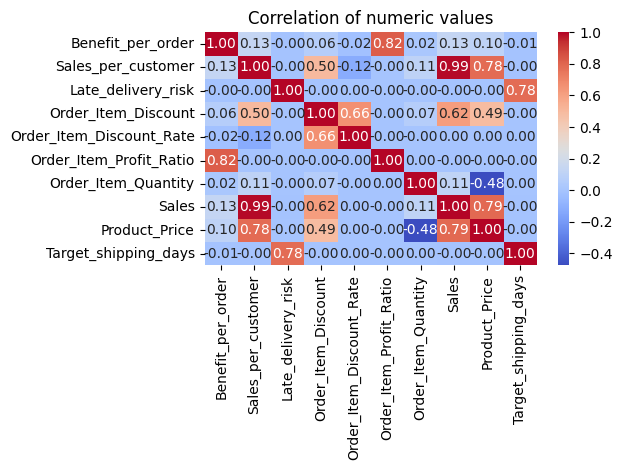

In [118]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=',.2f')
plt.title('Correlation of numeric values')
plt.tight_layout()
plt.savefig(f'graphs/others/Correlogram_of_numeric_values.png')

plt.show()

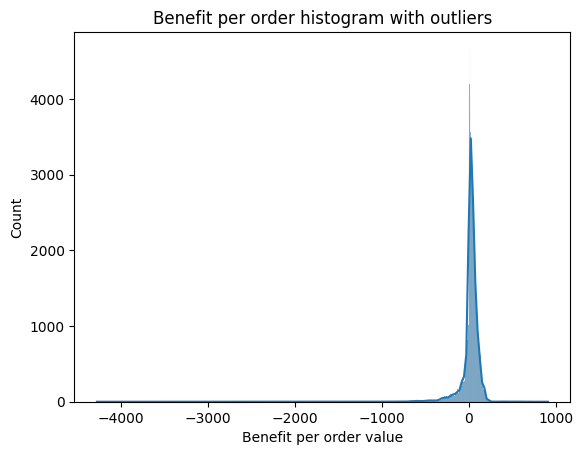

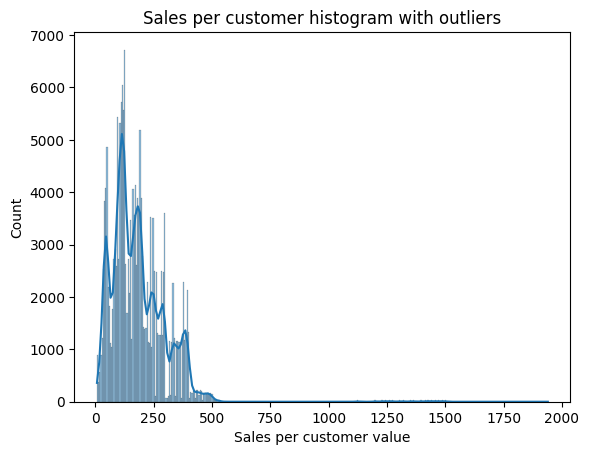

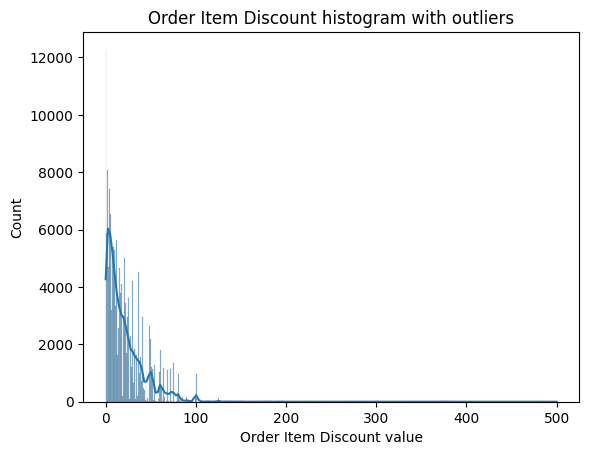

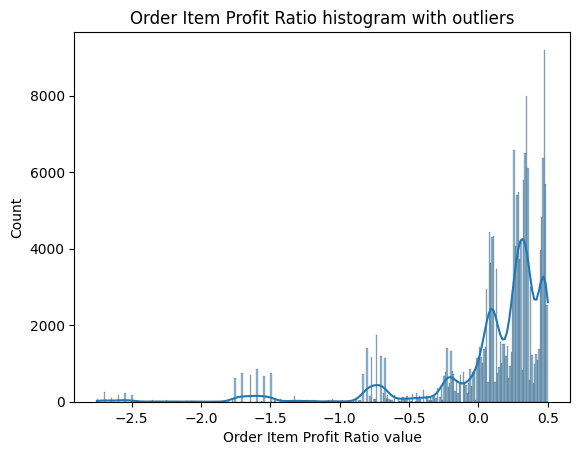

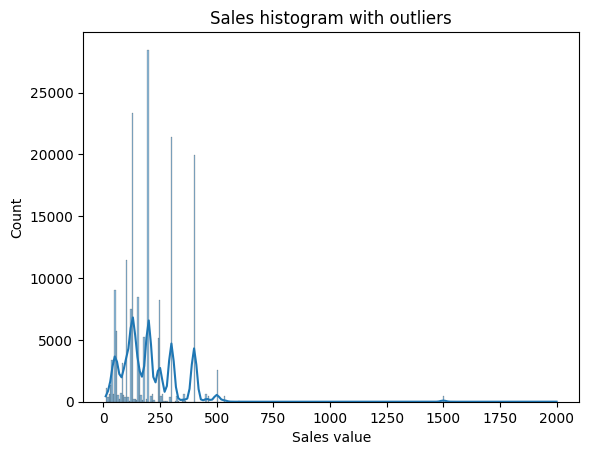

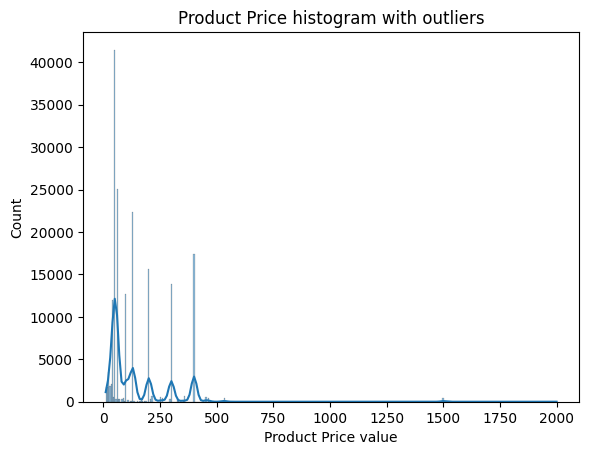

In [18]:
for c in continous_columns:
    sns.histplot(data=df, x=c, kde=True) # kde is our line representation of histogram
    plt.title(f'{c} histogram with outliers')
    plt.xlabel(f'{c} value')
    plt.ylabel('Count')
    ax = plt.gca()
    plt.savefig(f'graphs/histograms/{c}_histogram_with_outliers.png')
    plt.show()

Outliers in this dataset should not be deleted or replaced, as these are calculated correctly - our store has a few more pricey items, hence some of the higher sales, and since not all items in the store are profitable, we notice the negative benefits or profit ratios. These outliers give us a great information, at where we are losing money in the supply chain, since the benefits are greatly negative in those instances.

However, those orders are minority. I will create an additional dataset to get the look at majority of the data and then compare the majority distribution with the one with outliers. Later on in the analysis, we will take a look at those outliers to analyse, which products should be withdrawn from the offer, to avoid further losses.

In [19]:
outliers_in_columns = {}
for c in continous_columns:
    outliers_in_columns[c] = outliers(df, c)[0]

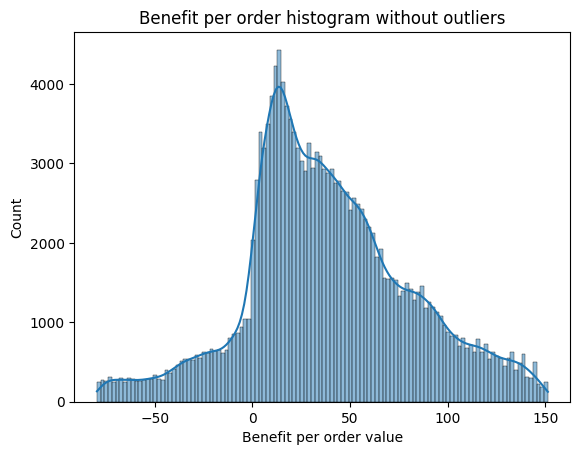

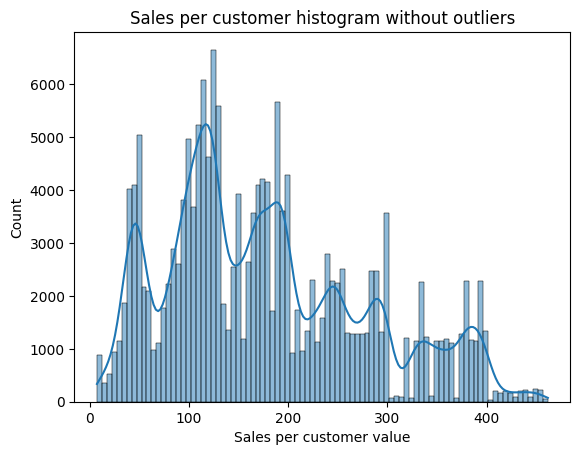

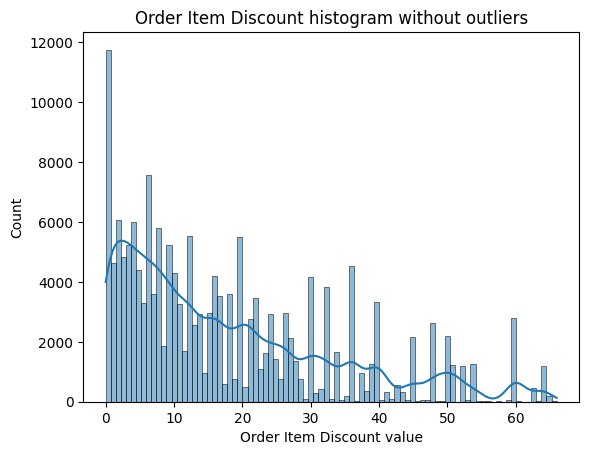

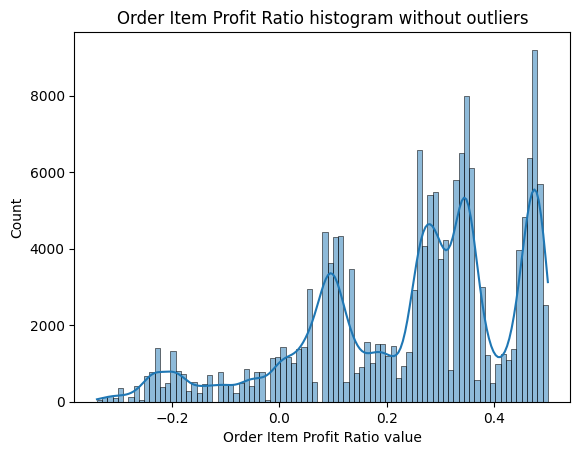

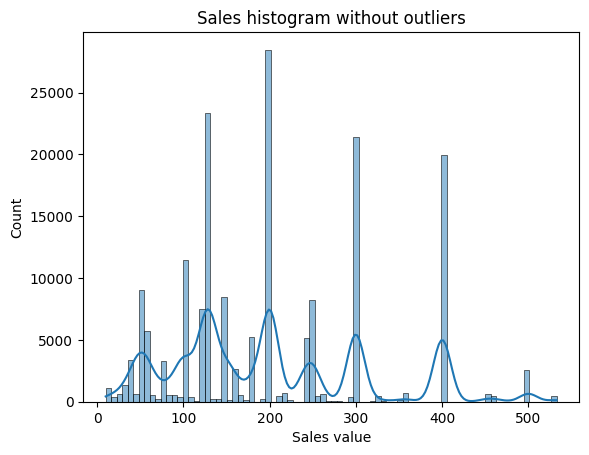

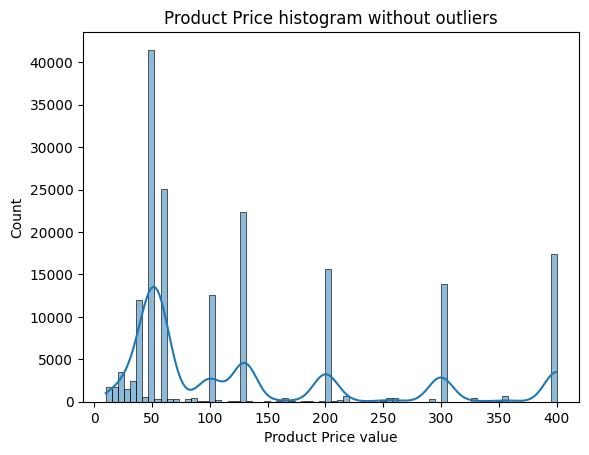

In [25]:
for c in continous_columns:
    filtered_df = df.drop(df[df[c].isin(outliers_in_columns[c])].index)
    sns.histplot(data=filtered_df, x=c, kde=True) # kde is our line representation of histogram
    plt.title(f'{c} histogram without outliers')
    plt.xlabel(f'{c} value')
    plt.ylabel('Count')
    ax = plt.gca()
    plt.savefig(f'graphs/histograms/{c}_histogram_without_outliers.png')
    plt.show()

**zlicz wszystkie wartości kategorii**
`df['name'].value_counts(ascending=False)`

może zbierz te, które mają mniejsze wartości niż ileś (średnia?) jako inne
`df[].apply(funkcja)`

jak znajdziesz ile zamawia się jakich produktów, wskaż top 5 i najgorsze 5 pod względem zysków i częstości wybierania
(pewnie da się to zrobić przez group by średnią albo count?)

pousuwać outliersy ale gdy zliczymy zamówienia? czy nje?

korelogram

zyski odnotowane ze sprzedaży na dzień, dla szeregu czasowego (to przy szeregach) 
lub liczba zamówień, albo oba

sprawdzić błądzenie losowe i whitenoise dla szeregu czasowego (zyski lub liczba zamówień)

czy są jakieś przesłanki dla opóźnionej wysyłki?
(klastrowanie?)

ABC analysis??co to??

## Zliczenie zamówień dla danych kategorycznych

In [6]:
def count_orders(dataframe, column, dictionary=None):
    orders = dataframe[column].value_counts(ascending=False)
    if dictionary:
        orders.index = orders.index.map(dictionary)
    return orders

def count_items_ordered(dataframe, column, dictionary=None):
    items = dataframe.groupby(column)['Order_Item_Quantity'].sum().sort_values(ascending=False)
    if dictionary:
        items.index = items.index.map(dictionary)
    return items

In [48]:
len(product_orders)

118

In [74]:
product_orders = count_orders(df, 'Product_Card_Id', product_name)
product_items_ordered = count_items_ordered(df, 'Product_Card_Id', product_name)

categories_orders = count_orders(df, 'Category_Id', category_name)
categories_items_ordered = count_items_ordered(df, 'Category_Id', category_name)

department_orders = count_orders(df, 'Department_Id', department_name)
department_items_ordered = count_items_ordered(df, 'Department_Id', department_name)

In [75]:
department_orders

Fan Shop              66861
Apparel               48998
Golf                  33220
Footwear              14525
Outdoors               9686
Fitness                2479
Discs Shop             2026
Technology             1465
Pet Shop                492
Book Shop               405
Health and Beauty       362
Name: Department_Id, dtype: int64

In [8]:
category_to_products = {}

for index, row in df.iterrows():
    category = row['Category_Id']
    product = row['Product_Card_Id']
    
    if category not in category_to_products:
        category_to_products[category] = set()

    category_to_products[category].add(product)

In [19]:
department_to_category = {}

for index, row in df.iterrows():
    department = row['Department_Id']
    category = row['Category_Id']
    
    if department not in department_to_category:
        department_to_category[department] = set()

    department_to_category[department].add(category)

In [20]:
department_to_product = {}

for index, row in df.iterrows():
    department = row['Department_Id']
    product = row['Product_Card_Id']
    
    if department not in department_to_product:
        department_to_product[department] = set()

    department_to_product[department].add(product)

## Plotting bars

In [119]:
barplots = ['Shipping_day', 'Order_day', 'Order_Status', 'Target_shipping_days', 'Late_delivery_risk']
piecharts = ['Type', 'Customer_Country', 'Customer_Segment', 'Shipping_Mode']


def create_barplot(dataframe, column, dictionary=None, title=None, path=None):
    if dictionary:
        orders = count_orders(dataframe, column, dictionary)
    else:
        orders = count_orders(dataframe, column)
            
    ax = sns.barplot(x=orders.index, y=orders)
    ax.bar_label(ax.containers[0])
    plt.title(f'Total orders per {column}', pad=20)
        
    plt.xlabel(f'{column}')
    plt.ylabel('Orders')
    if len(orders) > 7:
        plt.xticks(rotation=45, ha='right')
    
    ax.set_axisbelow(True)
    plt.grid(alpha=0.7)
    plt.tight_layout()

    plt.savefig(f'graphs/composition/{c}_barplot.png')
        
    plt.show()
    
def create_piechart(dataframe, column):
    orders = count_orders(dataframe, column)
    
    plt.figure(figsize=(5, 5))  # Rozmiar wykresu
    plt.pie(orders, labels=[f'{label}\n({size})' for label, size in zip(orders.index, orders)], autopct='', startangle=140)
    plt.title(f'Total orders per {column}', pad=20)
    plt.axis('equal') 
    plt.tight_layout()

    plt.savefig(f'graphs/composition/{c}_piechart.png')
    plt.show()


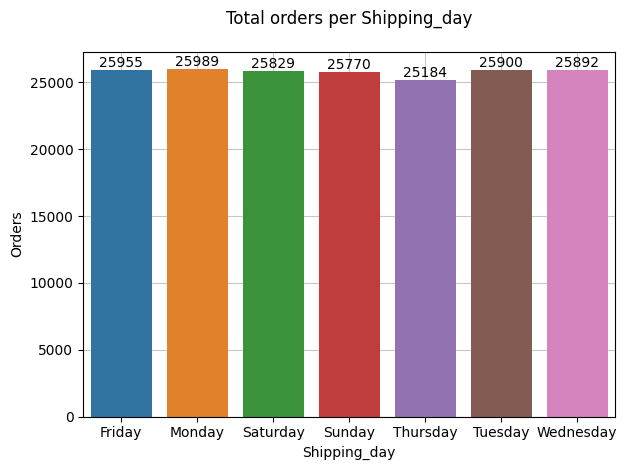

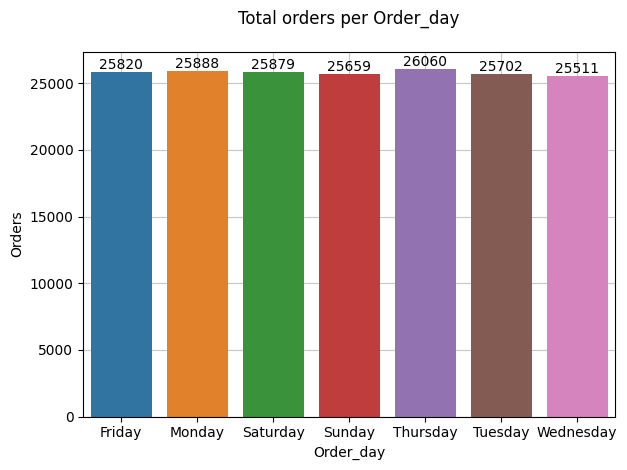

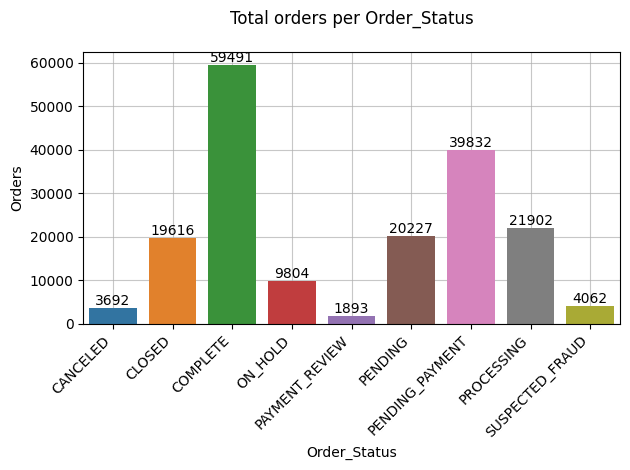

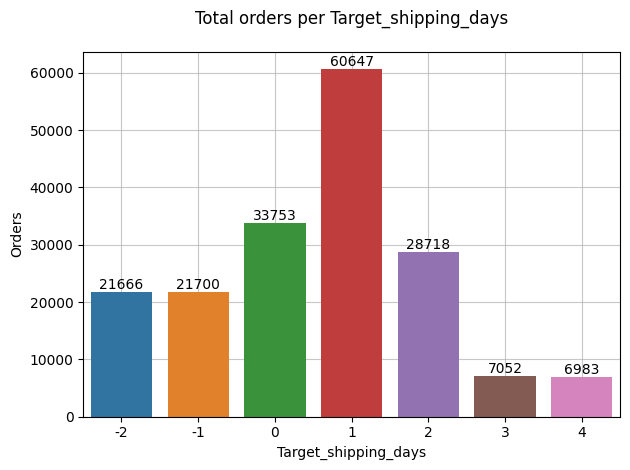

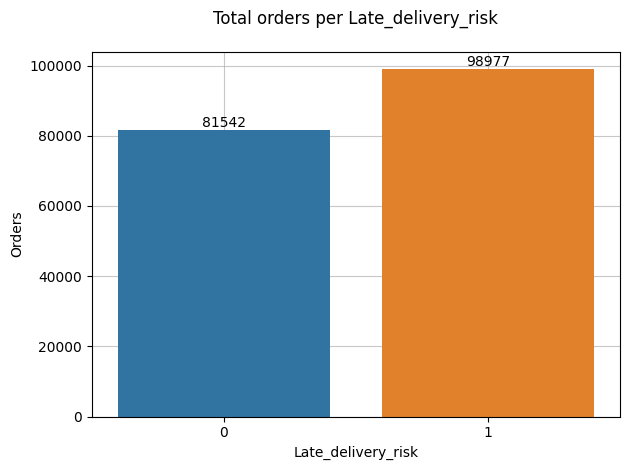

In [120]:
for c in barplots:
    create_barplot(df, c)

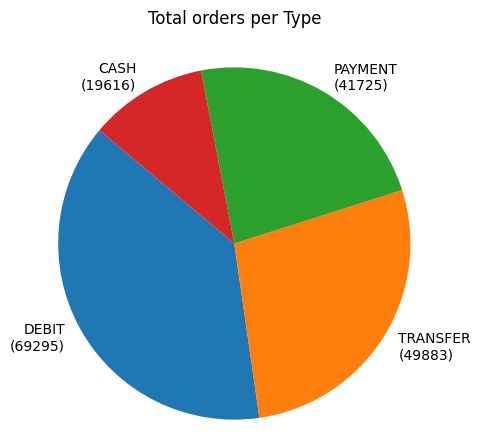

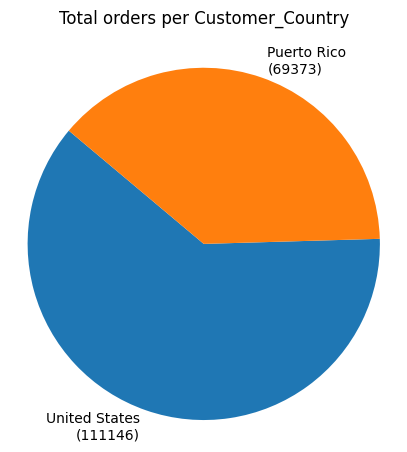

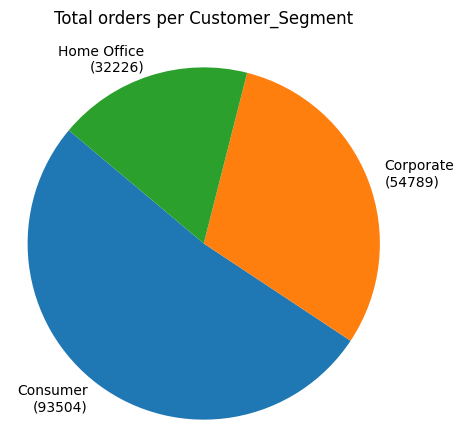

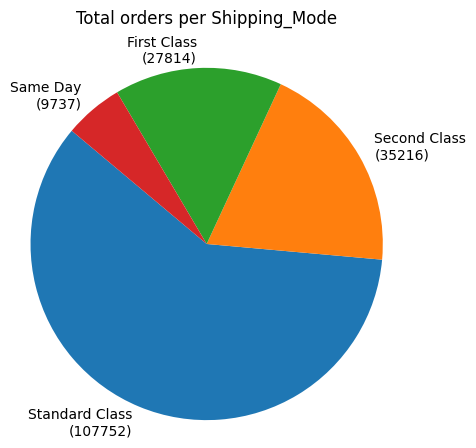

In [68]:
for c in piecharts:
    create_piechart(df, c)

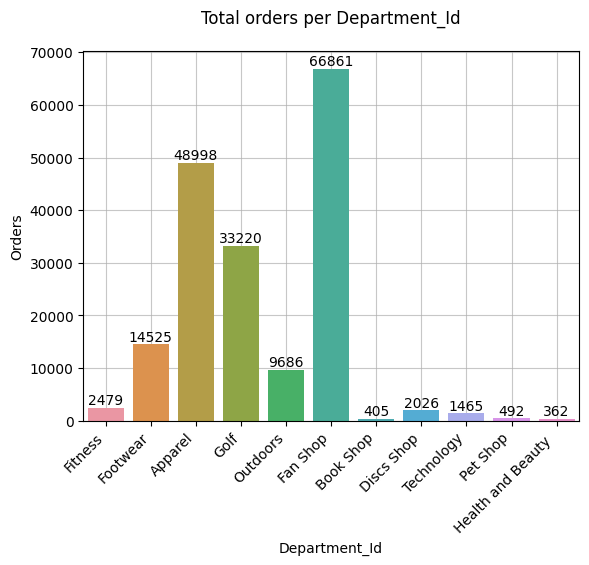

In [82]:
create_barplot('Department_Id', department_name)

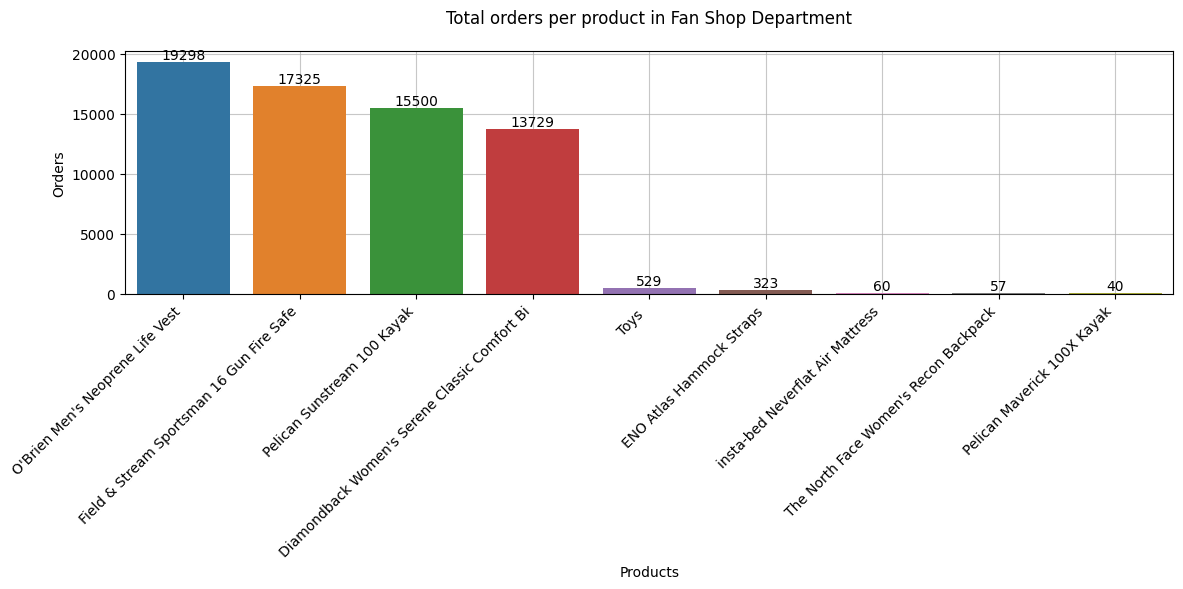

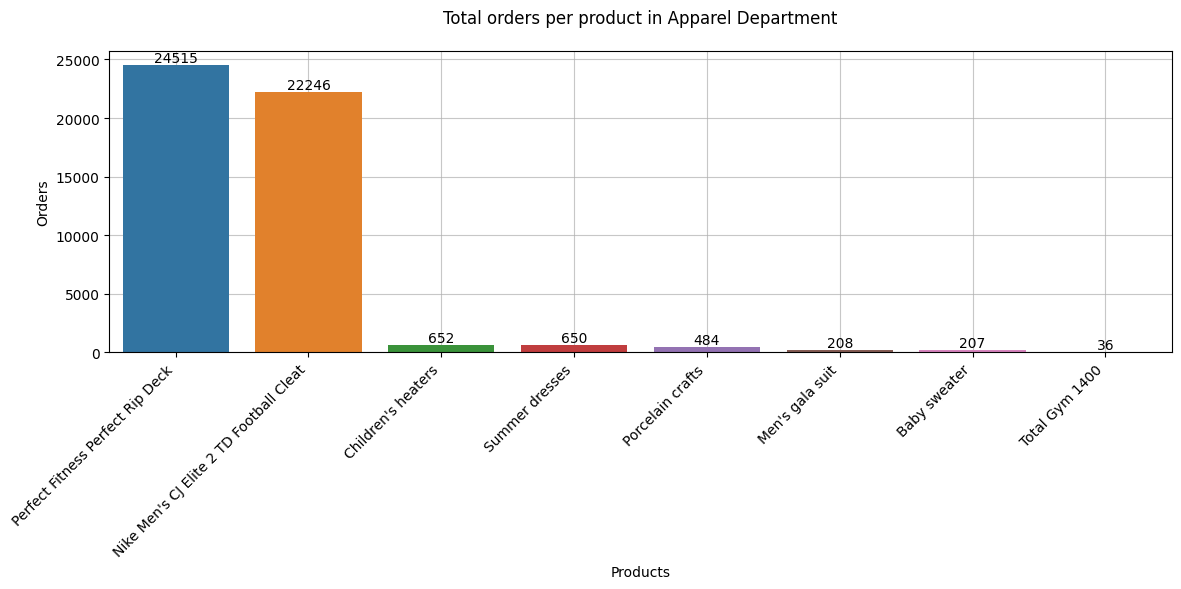

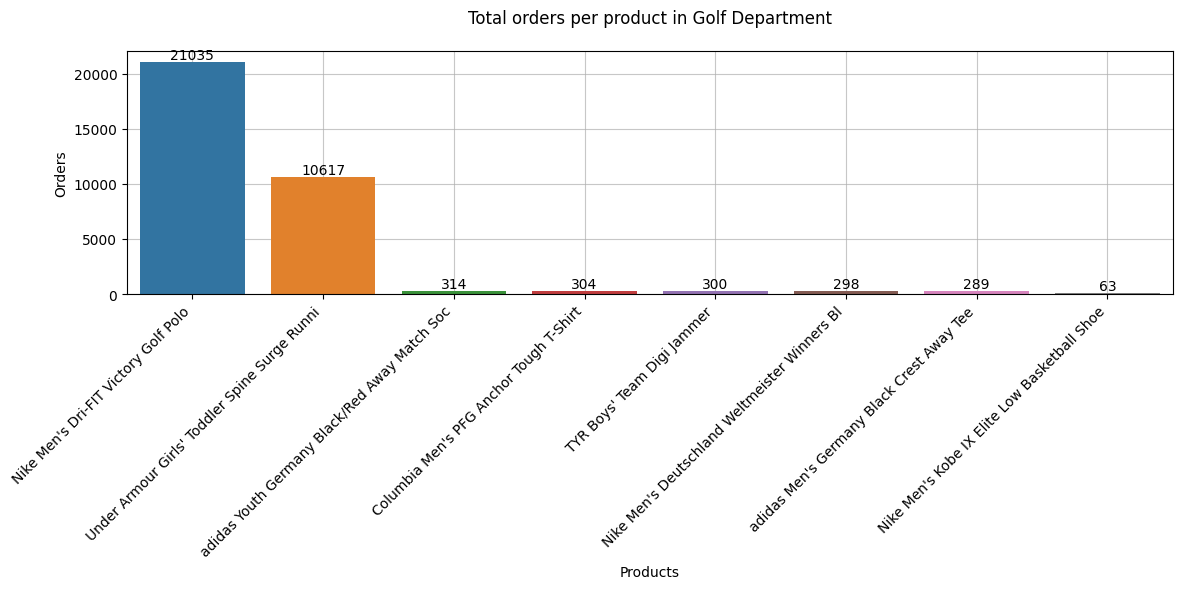

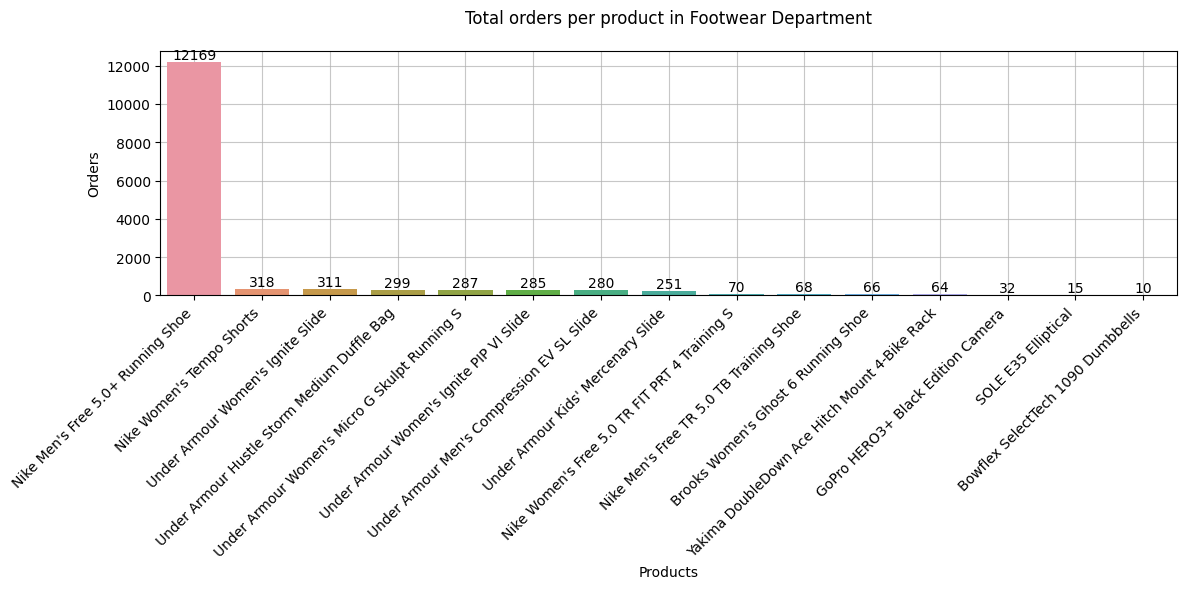

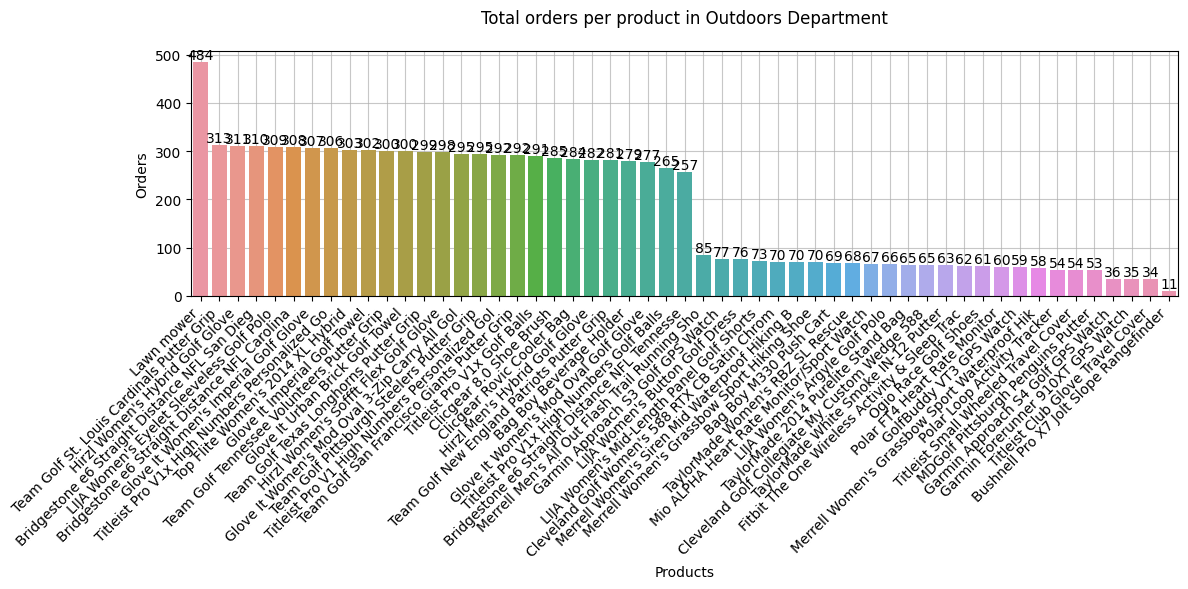

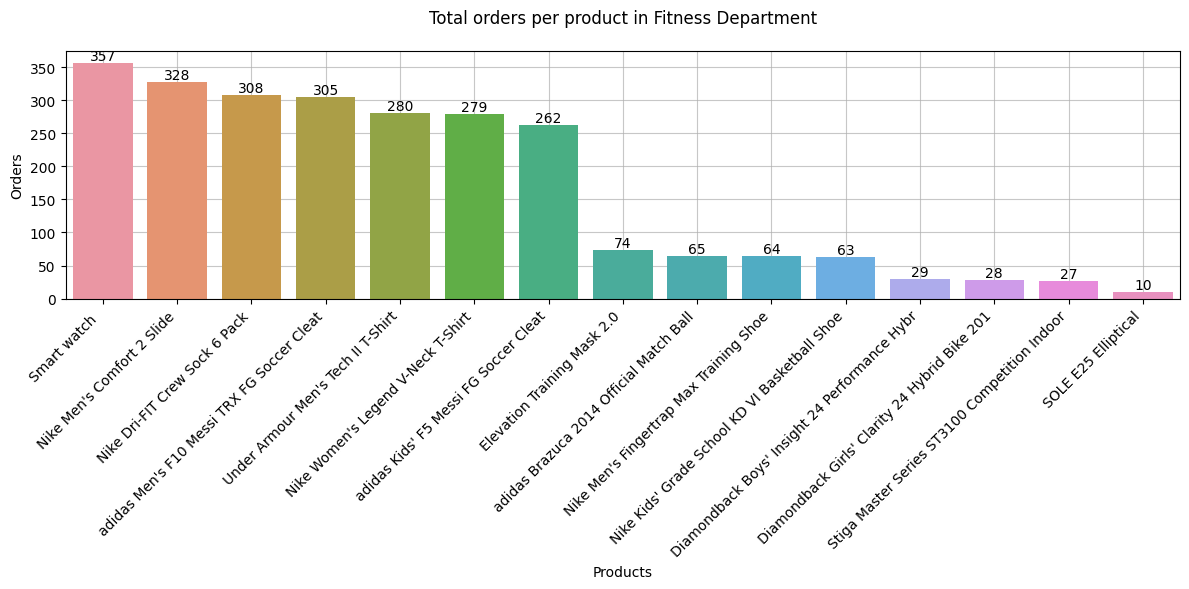

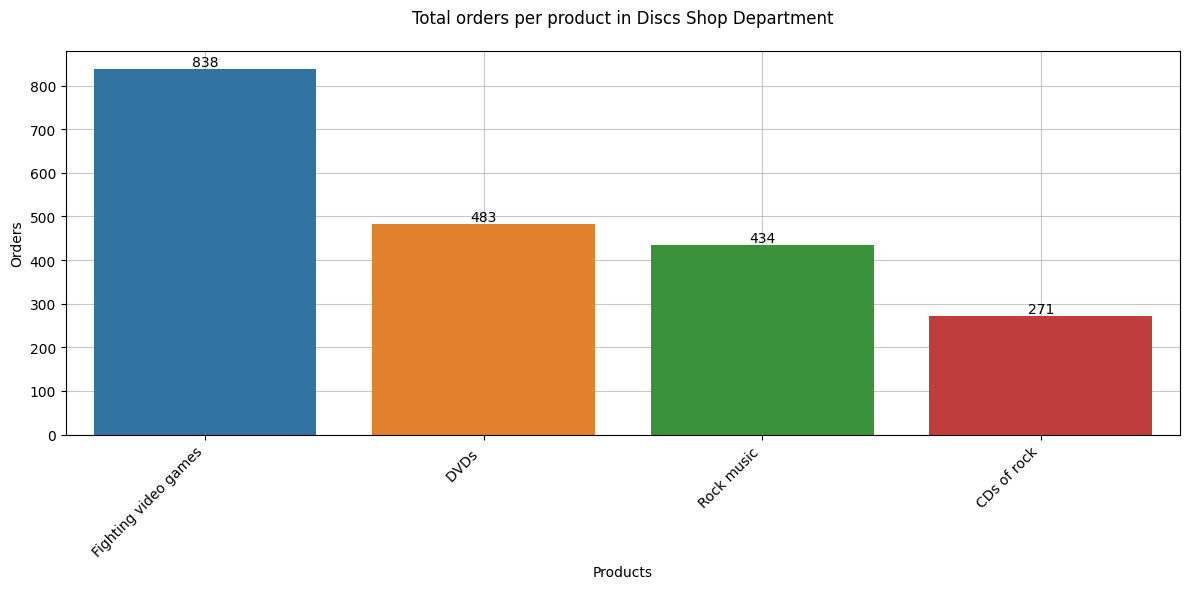

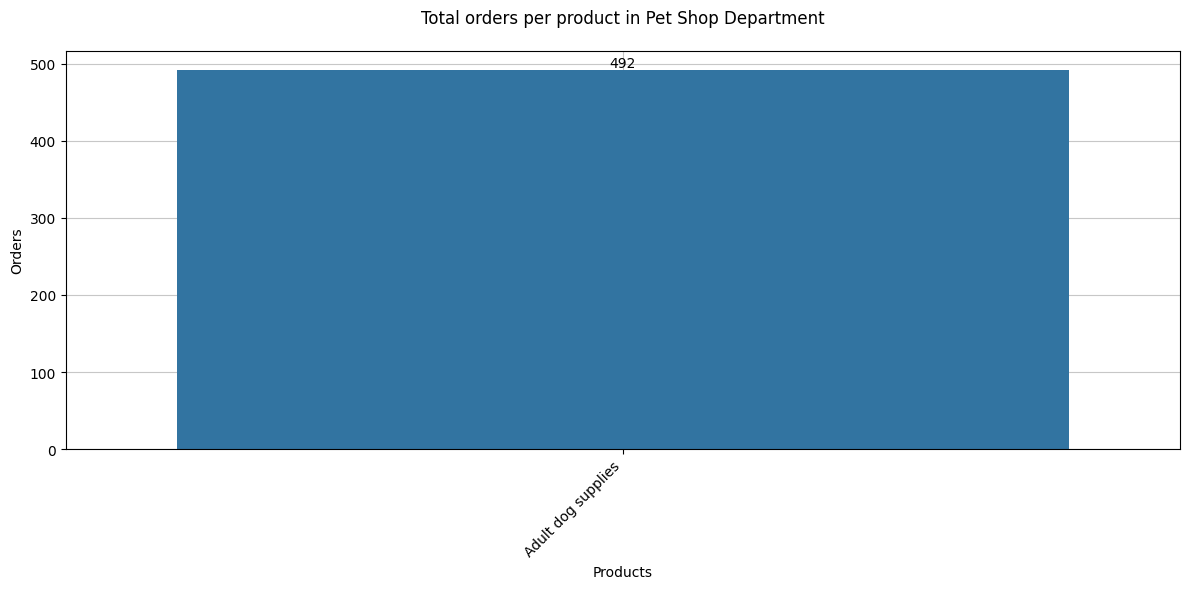

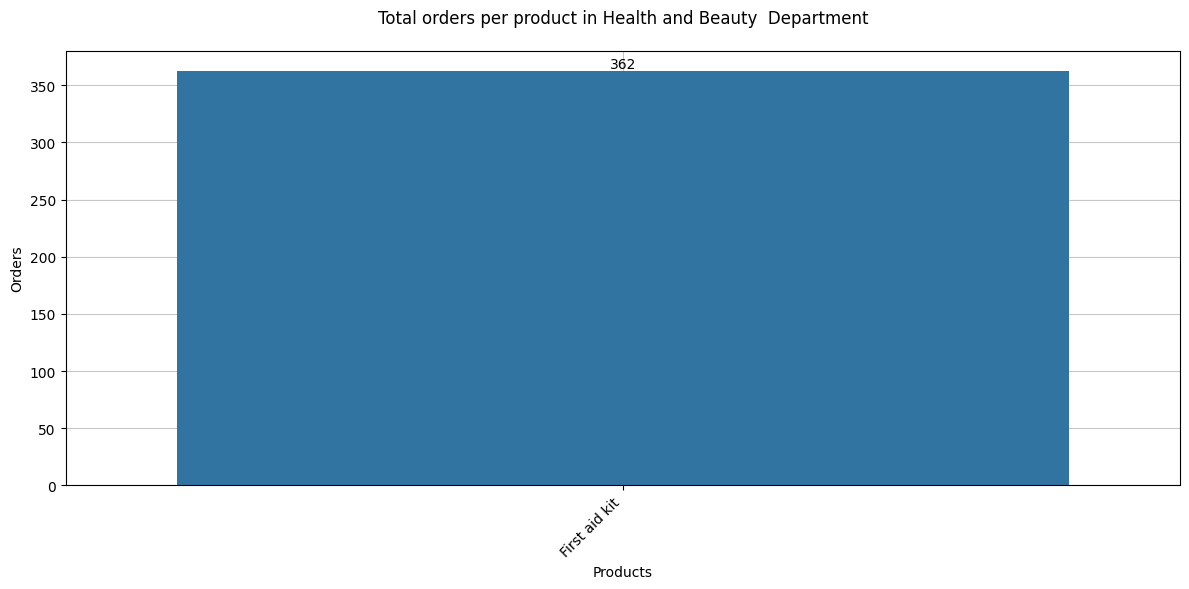

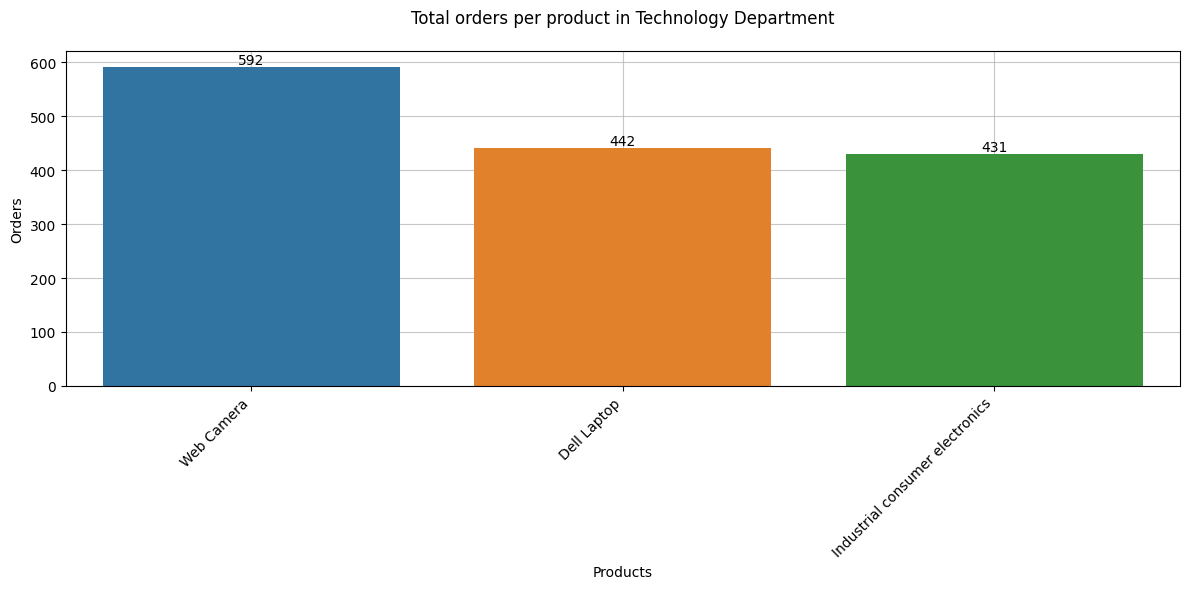

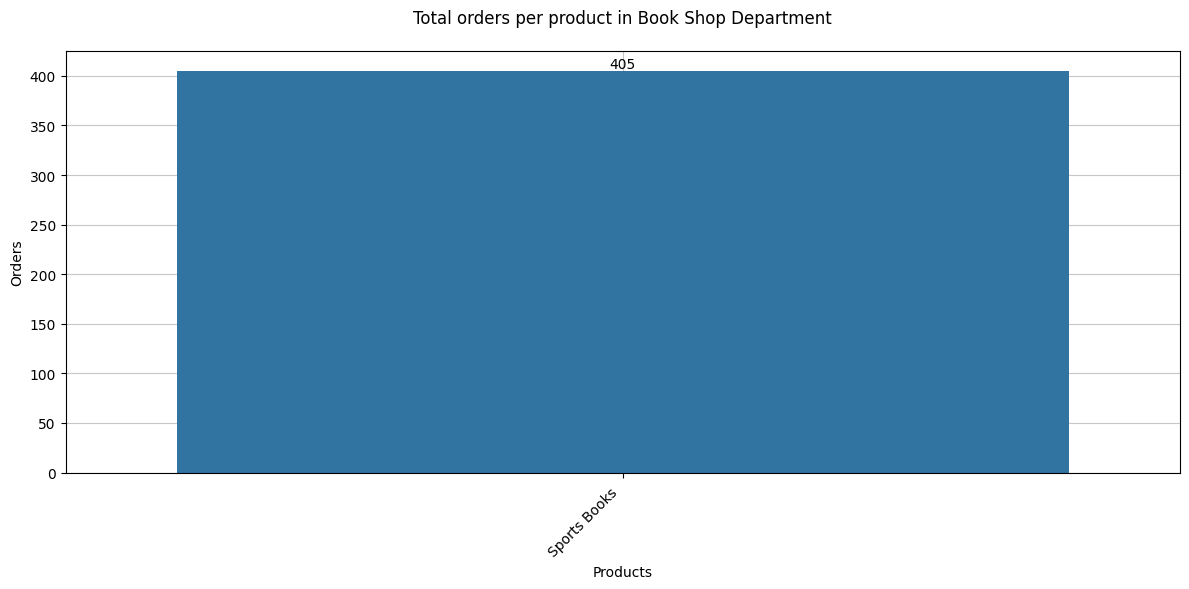

In [117]:
for dep in department_name.keys():
    df_dep = df[df['Department_Id'] == dep]
    
    # Tworzenie listy produktów, które występują tylko w df_dep
    unique_products = df_dep['Product_Card_Id'].unique()
    
    # Filtracja słownika product_name tylko do produktów występujących w df_dep
    product_name_filtered = {product_id: product_name[product_id] for product_id in unique_products}
    
    orders = count_orders(df_dep, 'Product_Card_Id', product_name_filtered)
            
    # Jeśli jest więcej niż 10 produktów, zwiększ rozmiar wykresu
    if len(orders) > 10:
        plt.figure(figsize=(12, 6))  # Dostosuj szerokość i wysokość wykresu
        
    ax = sns.barplot(x=orders.index, y=orders)
    ax.bar_label(ax.containers[0])
    plt.title(f'Total orders per product in {department_name[dep]} Department', pad=20)
        
    plt.xlabel('Products')
    plt.ylabel('Orders')
    if len(unique_products) > 7:
        plt.xticks(rotation=45, ha='right')
    
    ax.set_axisbelow(True)
    plt.grid(alpha=0.7)
    plt.tight_layout()

    plt.savefig(f'graphs/department/Dep{dep}_Product_orders_barplot.png')
        
    plt.show()


In [107]:
fraud_per_dep = df[df['Order_Status'] == 'SUSPECTED_FRAUD'].groupby('Department_Id').size().sort_values(ascending=False)
fraud_per_dep.index = fraud_per_dep.index.map(department_name)
fraud_per_dep

Department_Id
Fan Shop              1483
Apparel               1127
Golf                   744
Footwear               328
Outdoors               222
Fitness                 54
Discs Shop              39
Technology              32
Book Shop               11
Pet Shop                11
Health and Beauty       11
dtype: int64

In [114]:
most_losses = df.groupby('Product_Card_Id').agg({'Department_Id': 'unique',
                                                 'Benefit_per_order': 'mean'}).sort_values(by='Benefit_per_order')
most_losses.index = most_losses.index.map(product_name)
most_losses

,Department_Id,Benefit_per_order
Product_Card_Id,,
SOLE E35 Elliptical,"[3] Categories (11, int64): [2, 3, 4, 5, ..., ...",-64.34
Bushnell Pro X7 Jolt Slope Rangefinder,"[6] Categories (11, int64): [2, 3, 4, 5, ..., ...",-23.27
SOLE E25 Elliptical,"[2] Categories (11, int64): [2, 3, 4, 5, ..., ...",-16.96
CDs of rock,"[9] Categories (11, int64): [2, 3, 4, 5, ..., ...",1.42
Toys,"[7] Categories (11, int64): [2, 3, 4, 5, ..., ...",1.70
...,...,...
Polar FT4 Heart Rate Monitor,"[6] Categories (11, int64): [2, 3, 4, 5, ..., ...",57.95
Diamondback Boys' Insight 24 Performance Hybr,"[2] Categories (11, int64): [2, 3, 4, 5, ..., ...",59.68
Lawn mower,"[6] Categories (11, int64): [2, 3, 4, 5, ..., ...",69.10


In [109]:
df.head(1)

,Type,Benefit_per_order,Sales_per_customer,Late_delivery_risk,Category_Id,Customer_City,Customer_Country,Customer_Id,Customer_Segment,Customer_State,Department_Id,Market,Order_Country,Order_Id,Order_Item_Discount,Order_Item_Discount_Rate,Order_Item_Id,Order_Item_Profit_Ratio,Order_Item_Quantity,Sales,Order_Region,Order_Status,Product_Card_Id,Product_Price,Shipping_Mode,Shipping_date,Order_date,Order_time,Order_day,Shipping_time,Shipping_day,Target_shipping_days
0,CASH,88.79,239.98,0,43,Hickory,United States,11599,Consumer,NC,7,LATAM,México,1,60.00,0.20,1,0.37,1,299.98,Central America,CLOSED,957,299.98,Standard Class,2015-03-01,2015-01-01,00:00:00,Thursday,00:00:00,Sunday,-2


- which product categories are ordered most often; (ze zliczeń)
- which product categories are most often cancelled or possibly fraudulant; (done)
- which products in each category bring in the most and the least profit; (jutro)
- on which categories and which products is the company losing the most; (done)
- what are the most and least expensive products;
- which categories are the most and least expensive, and averages, distribution of prices, kurtosis;
- which categories are the most discounted ones;
- how many sales are made per customer and sales total per customer;
- if there are any trends in the order time and dates; (jutro - timeseries)
- if there is any weekly pattern in the shipement; (done)
- many others ;)